# IMDB Movie Reviews Sentiment Analysis using Pretrained Word Embeddings

### Pretrained word embeddings are said to be useful only if available data is very less and pretrained word embeddings. To prove this, this model will trained with small subset of IMDB train data and its evaluation performance on test data will be compared with that of model created with Jointly Learned word embeddings and trained with full training data.

### Preprocessed IMDB data that comes packaged with Keras is used here.


In [1]:
# Imports required packages

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
max_features = 10000    # count of most common words
embedding_dim = 100     # dimension of embedding
max_input_length = 500  # number of review words to into consideration

In [3]:
# Loads train and test data from preprocessed IMDB database that comes with Keras

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/pradip/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/pradip/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do

In [4]:
print("Train samples count:", x_train.shape[0],
      "\nTest samples count:", x_test.shape[0])

Train samples count: 25000 
Test samples count: 25000


In [5]:
# Pads reviews to be of same size

x_train = pad_sequences(x_train, maxlen = max_input_length)
x_test = pad_sequences(x_test, maxlen = max_input_length)

In [6]:
# Restricts number of training samples to 200 to prove the understanding mentioned in the title of this notebook

training_sample_count = 200

x_val = x_train[training_sample_count:]
y_val = y_train[training_sample_count:]

x_train = x_train[:training_sample_count]
y_train = y_train[:training_sample_count]

In [3]:
# Downloads and unzip GloVe - the pretrained word embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-04-09 18:31:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-09 18:31:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-09 18:31:08--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [7]:
# Creates embedding index

embedding_index = {}

glove_file_name = "glove.6B.100d.txt"
glove_file_path = os.path.join(os.getcwd(), glove_file_name)

file_stream = open(glove_file_path)
for line in file_stream:
    values = line.split()
    embedding_index[values[0]] = np.asarray(values[1:], dtype = "float32")
    
file_stream.close()

In [8]:
print("Number of words in the embedding index is:", len(embedding_index))

Number of words in the embedding index is: 400000


In [9]:
# Below steps prepare embedding matrix to be used to load the weights of embedding layer from



# Reverses the order of key and value pairs to consider only top 10000 (var max_features) words
index_word_dict = dict([(index, word) for (word, index) in imdb.get_word_index().items()])

# Creates embedding matrix with zero (0) as placeholder
embedding_matrix = np.zeros((max_features, embedding_dim))

for word_index in range(1, max_features+1):
    embedding_vector = embedding_index.get(index_word_dict[word_index])
    if embedding_vector is not None:
        embedding_matrix[word_index - 1] = embedding_vector

In [10]:
# Creates same model that was used with jointly learned embedding (refer other notebook)inde

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length = max_input_length))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [11]:
# Shows the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                1600032   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,600,065
Trainable params: 2,600,065
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Sets GloVe embedding matrix as weigths of the embedding layer and sets the layer as non-trainable

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [13]:
# Compiles the model

model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"])

In [14]:
# Fits the model

epochs = 10
batch_size = 32

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 18s 3s/step - loss: 7.2438 - acc: 0.5809 - val_loss: 0.7042 - val_acc: 0.5061
Epoch 2/10
7/7 [==============================] - 17s 3s/step - loss: 0.8562 - acc: 0.6378 - val_loss: 0.7210 - val_acc: 0.4992
Epoch 3/10
7/7 [==============================] - 16s 3s/step - loss: 0.6045 - acc: 0.6103 - val_loss: 0.7082 - val_acc: 0.5157
Epoch 4/10
7/7 [==============================] - 17s 3s/step - loss: 0.7248 - acc: 0.6265 - val_loss: 0.7962 - val_acc: 0.4984
Epoch 5/10
7/7 [==============================] - 19s 3s/step - loss: 0.6249 - acc: 0.6381 - val_loss: 2.5979 - val_acc: 0.4994
Epoch 6/10
7/7 [==============================] - 18s 3s/step - loss: 0.9514 - acc: 0.7138 - val_loss: 0.9374 - val_acc: 0.4994
Epoch 7/10
7/7 [==============================] - 17s 3s/step - loss: 0.5516 - acc: 0.7200 - val_loss: 0.7583 - val_acc: 0.4994
Epoch 8/10
7/7 [==============================] - 16s 3s/step - loss: 0.4887 - acc: 0.6692 - val_loss: 0

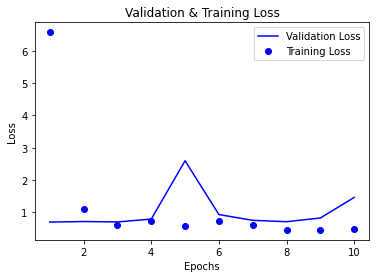

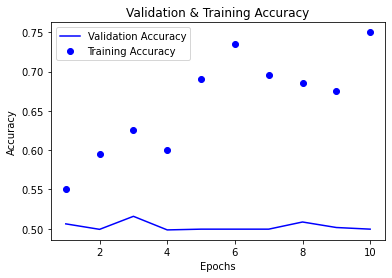

In [15]:
# Evaluates training and validation performance

history_dict = history.history

epoch_range = range(1, len(history_dict["acc"]) + 1)

train_losses = history_dict["loss"]
val_losses = history_dict["val_loss"]

train_accuracies = history_dict["acc"]
val_accuracies = history_dict["val_acc"]

plt.plot(epoch_range, val_losses, "b", label = "Validation Loss")
plt.plot(epoch_range, train_losses, "bo", label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation & Training Loss")


plt.figure()

plt.plot(epoch_range, val_accuracies, "b", label = "Validation Accuracy")
plt.plot(epoch_range, train_accuracies, "bo", label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation & Training Accuracy")

plt.show()

In [16]:
# Prints the validation performance

print("Validation Loss:", history_dict["val_loss"][-1],
      "\nValidation Accuracy:", history_dict["val_acc"][-1])

Validation Loss: 1.465273141860962 
Validation Accuracy: 0.4993951618671417


In [17]:
# Prints the test performance

eval_result = model.evaluate(x_test, y_test)

print("Test Loss:", eval_result[0],
      "\nTest Accuracy:", eval_result[1])

782/782 [==============================] - 21s 26ms/step - loss: 1.4764 - acc: 0.5000
Test Loss: 1.4763959646224976 
Test Accuracy: 0.5000399947166443


### Now, fit the model with same training data, but without the weights from the pretrained embeddings and find if pretrained embeddings actually helped to score any better on the same training set.

In [18]:
# Re-creates the same model

model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length = max_input_length))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

# Compiles the model

model.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["acc"])

# Fits the model
history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 15s 2s/step - loss: 1.2355 - acc: 0.5290 - val_loss: 0.7237 - val_acc: 0.4933
Epoch 2/10
7/7 [==============================] - 15s 3s/step - loss: 0.4826 - acc: 0.7369 - val_loss: 0.9322 - val_acc: 0.5015
Epoch 3/10
7/7 [==============================] - 18s 3s/step - loss: 0.4231 - acc: 0.7978 - val_loss: 1.1195 - val_acc: 0.5031
Epoch 4/10
7/7 [==============================] - 14s 2s/step - loss: 0.2172 - acc: 0.8955 - val_loss: 0.7748 - val_acc: 0.5195
Epoch 5/10
7/7 [==============================] - 19s 3s/step - loss: 0.0827 - acc: 0.9854 - val_loss: 0.7387 - val_acc: 0.5341
Epoch 6/10
7/7 [==============================] - 19s 3s/step - loss: 0.0452 - acc: 0.9944 - val_loss: 0.8121 - val_acc: 0.5233
Epoch 7/10
7/7 [==============================] - 16s 3s/step - loss: 0.0303 - acc: 0.9963 - val_loss: 0.8300 - val_acc: 0.5259
Epoch 8/10
7/7 [==============================] - 17s 3s/step - loss: 0.0179 - acc: 1.0000 - val_loss: 0

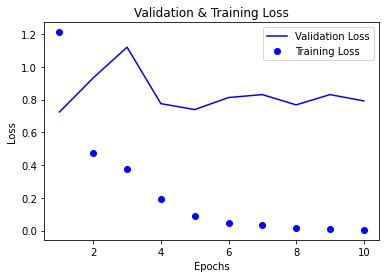

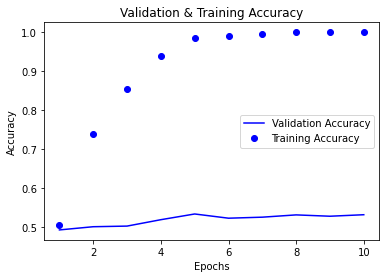

In [19]:
# Plots the training and validation performance, once again

history_dict = history.history

epoch_range = range(1, len(history_dict["acc"]) + 1)

train_losses = history_dict["loss"]
val_losses = history_dict["val_loss"]

train_accuracies = history_dict["acc"]
val_accuracies = history_dict["val_acc"]

plt.plot(epoch_range, val_losses, "b", label = "Validation Loss")
plt.plot(epoch_range, train_losses, "bo", label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation & Training Loss")


plt.figure()

plt.plot(epoch_range, val_accuracies, "b", label = "Validation Accuracy")
plt.plot(epoch_range, train_accuracies, "bo", label = "Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation & Training Accuracy")

plt.show()

In [20]:
# Prints the validation performance

print("Validation Loss:", history_dict["val_loss"][-1],
      "\nValidation Accuracy:", history_dict["val_acc"][-1])

Validation Loss: 0.791610062122345 
Validation Accuracy: 0.5322177410125732


In [21]:
# Prints the test performance

eval_result = model.evaluate(x_test, y_test)

print("Test Loss:", eval_result[0],
      "\nTest Accuracy:", eval_result[1])

782/782 [==============================] - 19s 24ms/step - loss: 0.8030 - acc: 0.5254
Test Loss: 0.8030348420143127 
Test Accuracy: 0.525439977645874


### CONCLUSION:

#### There are two observations.

#### 1) When data is scarce - 200 training samples in this case, there was no significant gain in terms of achieving higher test accuracy when pretained word embeddings were used, and test performance of the model with jointly learned word embeddings even did little better!. In fact latter one did well by 2% (~52% vs. ~50%).

#### 2) When word embeddings were jointly learned in the previous notebook with all 25000 training data, test accuracy as high as ~83% was achieved. But it could not beat the baselined model (in notebook <em>1_IMDB_Movie_Review_Sentiment_Analysis_using_Densed_Neural_Network.ipynb</em>) that achieved ~85% test accuracy.

#### It is clear from the above test data evaluation result that task specific joinltly learned embeddings perfor better when data is not scarce, and pretrained might (or might not) be of help when less data is available.

#### Other configuration such as 100 dimentional embedding vectors, top 10000 words and first 500 top review words were kept common for all the models.

#### Refer next notebook that will use Recurrent Neural Networks (RNN) to check if it performs better than any of these approaches used so far.